In [1]:
from latentmi import lmi
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
import scanpy as sc 
from tqdm.notebook import tqdm
import os

/home/gokul/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


loop through each folder in PBMC_CITE_seq embeddings
estimate MI
record in df

In [2]:
# base directory for embeddings
embeddings_dir = '../embeddings/PBMC_CITEseq/'
results = []

# loop through quality and replicate subdirectories
for quality_dir in os.listdir(embeddings_dir):
    quality_path = os.path.join(embeddings_dir, quality_dir)
    if not os.path.isdir(quality_path):
        continue

    # find held-out cells
    held_out_path = os.path.join(quality_path, 'held_out_cells.h5ad')
    held_out = sc.read_h5ad(held_out_path)

    UMI_per_cell = held_out.raw.X.sum()/len(held_out)

    protein_counts = held_out.obsm['protein_counts']

    celltype_coarse = pd.get_dummies(held_out.obs['celltype.l1']).to_numpy()
    celltype_fine = pd.get_dummies(held_out.obs['celltype.l3']).to_numpy()

    # loop through embedding files
    for file in tqdm(os.listdir(quality_path), desc=f"Processing {quality_dir}"):
        if not file.endswith('.npy'):
            continue

        # extract method and fraction from filename
        method, frac = file.split('_')
        frac = frac[4:-4]

        # load embeddings
        embedding_path = os.path.join(quality_path, file)
        embeddings = np.load(embedding_path)

        # estimate MI
        pmis, _, _ = lmi.estimate(embeddings, protein_counts, quiet=True, batch_size=2048)
        protein_mi = np.nanmean(pmis)

        # estimate MI for cell type
        pmis, _, _ = lmi.estimate(embeddings, celltype_coarse, quiet=True, batch_size=2048)
        ct_coarse_mi = np.nanmean(pmis)

        pmis, _, _ = lmi.estimate(embeddings, celltype_fine, quiet=True, batch_size=2048)
        ct_fine_mi = np.nanmean(pmis)

        # save result
        results.append({
            'Quality': quality_dir.split('_')[0],
            'UMI per cell' : UMI_per_cell,
            'Replicate': quality_dir.split('_')[1],
            'Fraction': float(frac),

            # watch out ! this needs to be tweaked if we change hold out size
            'Cell number' : int(float(frac)*3*len(held_out)),
            'Method': method,
            'Protein MI': protein_mi,
            'Cell type coarse MI': ct_coarse_mi,
            'Cell type fine MI': ct_fine_mi
        })

Processing Q0.001_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.002_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 246 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.005_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 245 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.010_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.022_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.046_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.100_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.215_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q0.464_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

Processing Q1.000_rep0:   0%|          | 0/37 [00:00<?, ?it/s]

epoch 299 (of max 300) 🌻🌻🌻🌻🌻🌻🌻🌻🌻

In [3]:
df = pd.DataFrame(results)
df

,Quality,UMI per cell,Replicate,Fraction,Cell number,Method,Protein MI,Cell type coarse MI,Cell type fine MI
0,Q0.001,8.166369,rep0,0.001,114,VAE,0.319425,0.334736,0.407495
1,Q0.001,8.166369,rep0,0.001,114,PCA,0.353062,0.344677,0.387297
2,Q0.001,8.166369,rep0,0.001,114,RandomProjection,0.375344,0.322267,0.373018
3,Q0.001,8.166369,rep0,0.001,114,nanoTxformer,0.339669,0.407248,0.437265
4,Q0.001,8.166369,rep0,0.004,456,VAE,0.337705,0.282243,0.363841
...,...,...,...,...,...,...,...,...,...
205,Q1.000,8153.868320,rep0,0.251,28632,RandomProjection,2.977235,2.027267,2.717113
206,Q1.000,8153.868320,rep0,0.251,28632,nanoTxformer,3.004645,2.184671,2.910502
207,Q1.000,8153.868320,rep0,1.000,114072,VAE,4.634084,2.360198,3.688411
208,Q1.000,8153.868320,rep0,1.000,114072,PCA,4.441343,2.180160,3.416935


In [7]:
df.to_csv('../results/PBMC_CITEseq_scaling.csv')

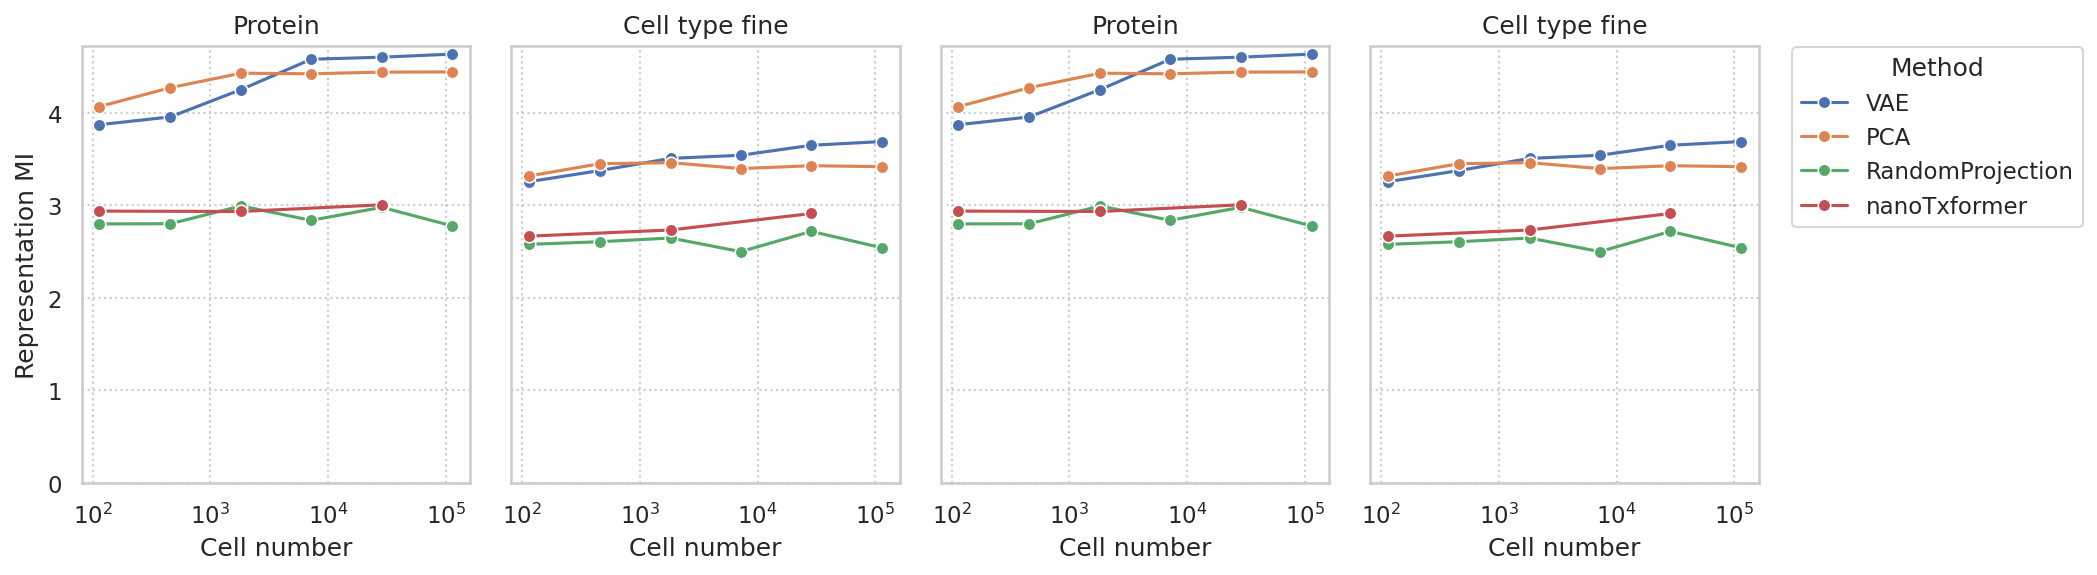

In [11]:
df = pd.read_csv('../results/PBMC_CITEseq_scaling.csv')

# set seaborn style
sns.set(style="whitegrid", rc={"grid.linestyle": ":"})  # dotted grid lines!

# create subplots
fig, axes = plt.subplots(1, 4, figsize=(12, 4), dpi=150, sharey=True)

# plot specific sns.lineplot on each subplot
to_plot = ['Protein MI', 'Cell type fine MI'] * 2
for i in range(4):
    ax = axes[i]

    g = sns.lineplot(
        data=df[df['Quality'] == 'Q1.000'],
        x='Cell number',
        y=to_plot[i],
        hue='Method',
        marker='o',
        ax=ax
    )
    g.set_xscale('log')  # log scale for x-axis
    g.set_ylim(0)
    g.set_title(to_plot[i][:-3])
    ax.get_legend().remove()  # remove duplicate legends

# add a single legend on the right side
handles, labels = axes[0].get_legend_handles_labels()  # grab from first plot
fig.legend(handles, labels, loc='center right', title="Method", bbox_to_anchor=(1.17, 0.75))
axes[0].set_ylabel('Representation MI')

plt.subplots_adjust(right=0.85)  # make space for the legend
plt.tight_layout()
plt.show()


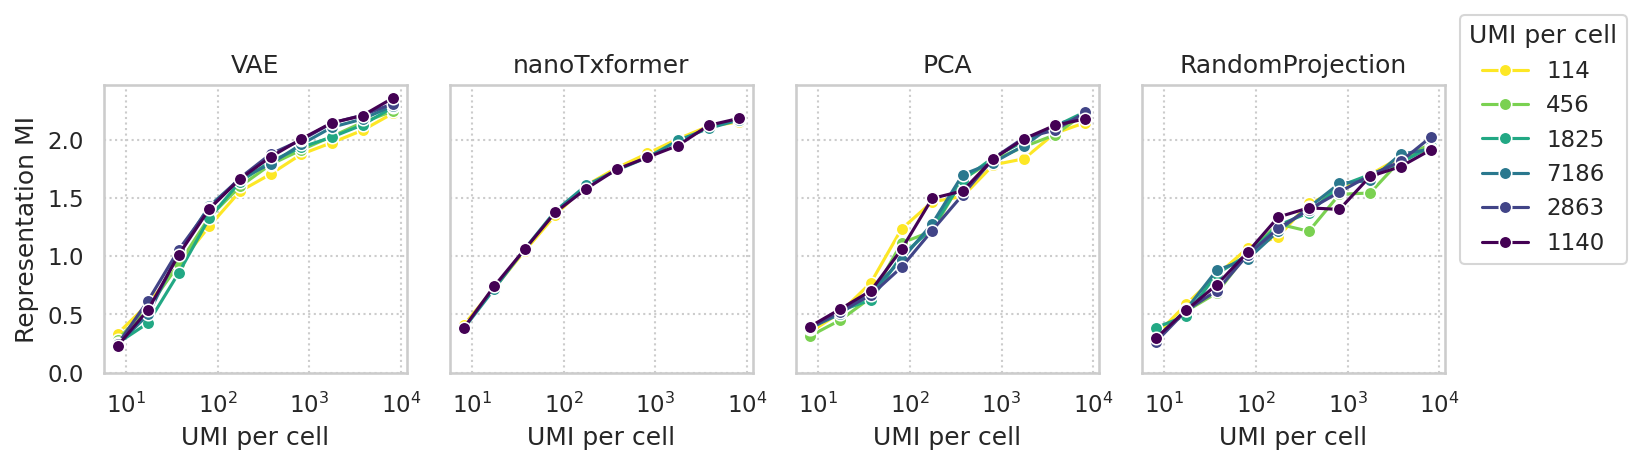

In [21]:
from matplotlib.colors import LogNorm

# create subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 3), dpi=150, sharey=True)

# plot specific sns.lineplot on each subplot
to_plot = ['VAE', 'nanoTxformer', 'PCA', 'RandomProjection']
for i in range(4):
    ax = axes[i]

    g = sns.lineplot(
        data=df[df['Method'] == to_plot[i]],
        x='UMI per cell',
        y='Cell type coarse MI',
        hue='Cell number',
        marker='o',
        hue_norm=LogNorm(),
        palette='viridis_r',
        ax=ax
    )
    g.set_xscale('log')  # log scale for x-axis
    g.set_ylim(0)
    g.set_title(to_plot[i])
    ax.get_legend().remove()  # remove duplicate legends

# add a single legend on the right side
handles, labels = axes[0].get_legend_handles_labels()  # grab from first plot
labels = [x[:4] for x in labels]
fig.legend(handles, labels, loc='center right', title="UMI per cell", bbox_to_anchor=(1.1, 0.75))
axes[0].set_ylabel('Representation MI')

plt.subplots_adjust(right=0.85)  # make space for the legend
plt.tight_layout()
plt.show()


/tmp/ipykernel_2847984/1878070256.py:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = get_cmap('tab10')


5.397850178492103
3.7872824533927365
2.28145487493561


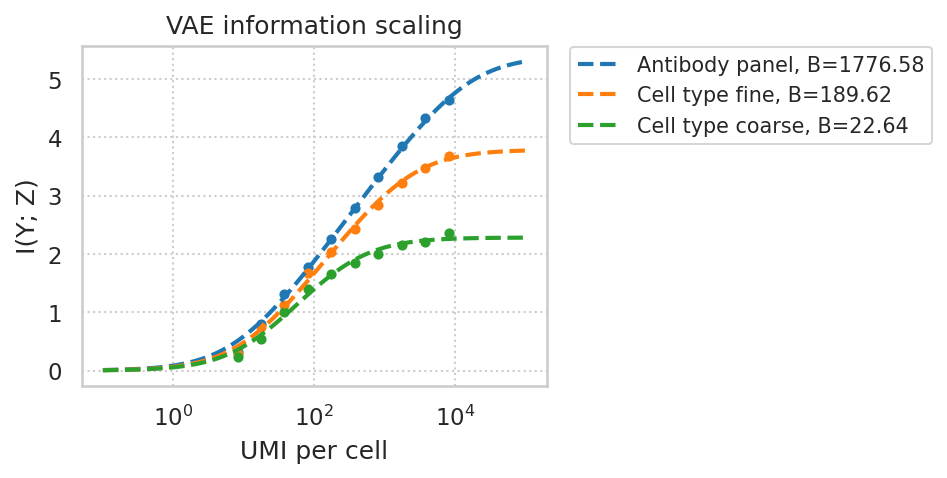

In [47]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
from matplotlib.cm import get_cmap

def info_scaling(x, A, B):
    return 0.5 * np.log2((B+1)*(B+A*(1/x))/(B+A*(1/x)+B*A*(1/x)))

# group and filter data
filtered_df = df[df['Cell number'] > 5 * 10**4]
filtered_df = filtered_df[filtered_df['Method'].isin(['VAE'])]
grouped = filtered_df.groupby(['Method', 'Cell number'])

# setup plot
rcParams['figure.dpi'] = 150
x_fit = np.logspace(-1, 5, 100)
cmap = get_cmap('tab10')

plt.figure(figsize=(4, 3))
for (representation, n_cells), group in grouped:
    x_data = group['UMI per cell']
    y_data = group['Protein MI']
    plt.scatter(x_data, y_data, color=cmap(0), s=15)
    try:
        popt, pcov = curve_fit(info_scaling, x_data, y_data, p0=[1.0, 1.0])
        A_fit, B_fit = popt
        print(0.5*np.log2(B_fit + 1))
        plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                    label=f"Antibody panel, B={B_fit:.2f}", 
                    color=cmap(0), lw=2)
    except RuntimeError:
        print(f"Fit failed for Rep {representation}, N cells {n_cells}")

    for (representation, n_cells), group in grouped:
        x_data = group['UMI per cell']
        y_data = group['Cell type fine MI']
        plt.scatter(x_data, y_data, color=cmap(1), s=15)
        try:
            popt, pcov = curve_fit(info_scaling, x_data, y_data, p0=[1.0, 1.0])
            A_fit, B_fit = popt
            print(0.5*np.log2(B_fit + 1))
            plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                        label=f"Cell type fine, B={B_fit:.2f}", 
                        color=cmap(1), lw=2)
        except RuntimeError:
            print(f"Fit failed for Rep {representation}, N cells {n_cells}")
    
    for (representation, n_cells), group in grouped:
        x_data = group['UMI per cell']
        y_data = group['Cell type coarse MI']
        plt.scatter(x_data, y_data, color=cmap(2), s=15)
        try:
            popt, pcov = curve_fit(info_scaling, x_data, y_data, p0=[1.0, 1.0])
            A_fit, B_fit = popt
            print(0.5*np.log2(B_fit + 1))
            plt.plot(x_fit, info_scaling(x_fit, A_fit, B_fit), linestyle='dashed',
                        label=f"Cell type coarse, B={B_fit:.2f}", 
                        color=cmap(2), lw=2)
        except RuntimeError:
            print(f"Fit failed for Rep {representation}, N cells {n_cells}")

# finalize plot
plt.xscale('log')
plt.xlabel("UMI per cell")
plt.ylabel("I(Y; Z)")
plt.title("VAE information scaling")
plt.legend(loc=(1.05, .71), fontsize="small", ncol=1)
plt.show()
